In [20]:
import numpy as np
import pandas as pd
import sys
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("/Users/clemens/Documents/Code/AnalysisToolbox")

import spikeAnalysisToolsV2.data_loading as data
import spikeAnalysisToolsV2.firing_rates as firing
import spikeAnalysisToolsV2.helper as helper
import spikeAnalysisToolsV2.overviews as overview
import spikeAnalysisToolsV2.information_scores as info
import spikeAnalysisToolsV2.plotting as spikeplot
import spikeAnalysisToolsV2.combine_stimuli as combine

In [21]:
## set the Masterpath to the folder where your output is saved
epochs = range(1, 200, 1)

masterpath = "/Users/clemens/Documents/Code/ModelClemens/output"
## set the subfolder to the Simulation you want to analyse 

subfolders = [
    "0_collections/copare_loc_1_and_2/11_17-15_19_loc1_l_vs_r_lr80"
            ]
## if more than the inital epoch is needed *1 needs to be run
extensions = ["initial"] + ["testing/epoch{}".format(n) for n in epochs]

object_list = data.load_testing_stimuli_info(masterpath+"/" + subfolders[0]) #assuming all the subfolders have the same
n_stimuli = np.sum(obj['count'] for obj in object_list)

current_index=0
object_indices = []
for obj in object_list:
    object_indices.append(list(range(current_index, current_index + obj['count'])))
    current_index += obj["count"]

# info_neurons is just an array of the information from above. This makes it easier to run the functions and pass the information. 
# info_times same for times
network_architecture = dict(
    num_exc_neurons_per_layer = 64*64,
    num_inh_neurons_per_layer = 32*32,
    num_layers = 4,
    #total_per_layer = num_exc_neurons_per_layer + num_inh_neurons_per_layer,
    #total_network = total_per_layer * num_layers,
    #num_stimuli = 16
)

info_times = dict(
    length_of_stimulus = 2.0,
    num_stimuli = n_stimuli,
    time_start = 1.5,
    time_end = 1.9
)

#objects = [list(range(28)),list(range(28, 28+28))]# each is presented twice
#object_indices
object_list

[{'count': 8,
  'elements': {'1bcl', '1bdl', '1wcl', '1wdl'},
  'indices': [0, 1, 2, 3, 4, 5, 6, 7]},
 {'count': 8,
  'elements': {'1bcr', '1bdr', '1wcr', '1wdr'},
  'indices': [8, 9, 10, 11, 12, 13, 14, 15]}]

In [22]:
spikes = data.load_spikes_from_subfolders(masterpath, subfolders, extensions, False)
print("loading done")
# rates_subfolders = firing.slow_calculate_rates_subfolder(
#     spikes,
#     network_architecture, 
#     info_times)
# print("Non multiprocessing version took {}".format(timer() - start))

start = timer()
rates_subfolders = firing.calculate_rates_subfolder(
    spikes,
    network_architecture, 
    info_times)
print("Multiprocessing version took {}".format(timer() - start))


Start
loading done
Multiprocessing version took 73.11066546998336


In [23]:
exc_information, inhibitory_information = info.single_cell_information_all_epochs(rates_subfolders[0], object_indices, 3)
exc_higher_z_resp, inh_higher_z_resp   = info.average_higher_z_response_all_epochs(rates_subfolders[0], object_indices)
exc_mutual_info , _inh_mutual_info = info.information_all_epochs(rates_subfolders[0],'mutual_info', objects=object_indices, n_bins=3)
print(object_indices)

Choosen Strategy: firing_rates_to_single_cell_information, || 
   Single Cell information
   :param firing_rates: nested list of shape [stimulus][layer][exc/inh] -> pandas dataframe with fields "ids", "firing_rate"
   :param objects:
   :param n_bins: how many bins the firing rates are sorted into (to make the firing rates discrete)
   :param calc_inhibitory: Flag (to save time)
   :return:
   
Choosen Strategy: average_higher_z_response_to_object, || 
    A value for each neuron iff that neuron has a higher average response to a presentation of object object_ID.
    The value is the factor of standardiviations (along the responses of the neuron to different stimuli presentations)
    by which the neurons average response is higher.

   :param firing_rates: nested list of shape [stimulus][layer][exc/inh] -> pandas dataframe with fields "ids", "firing_rate"
   :param objects: list containing a list of stimulus_ids that belong to one object
   :param min_difference: the minimal number of

#### Finding Neurons with different information for different Objects

### Information Development
#### Mutual Information

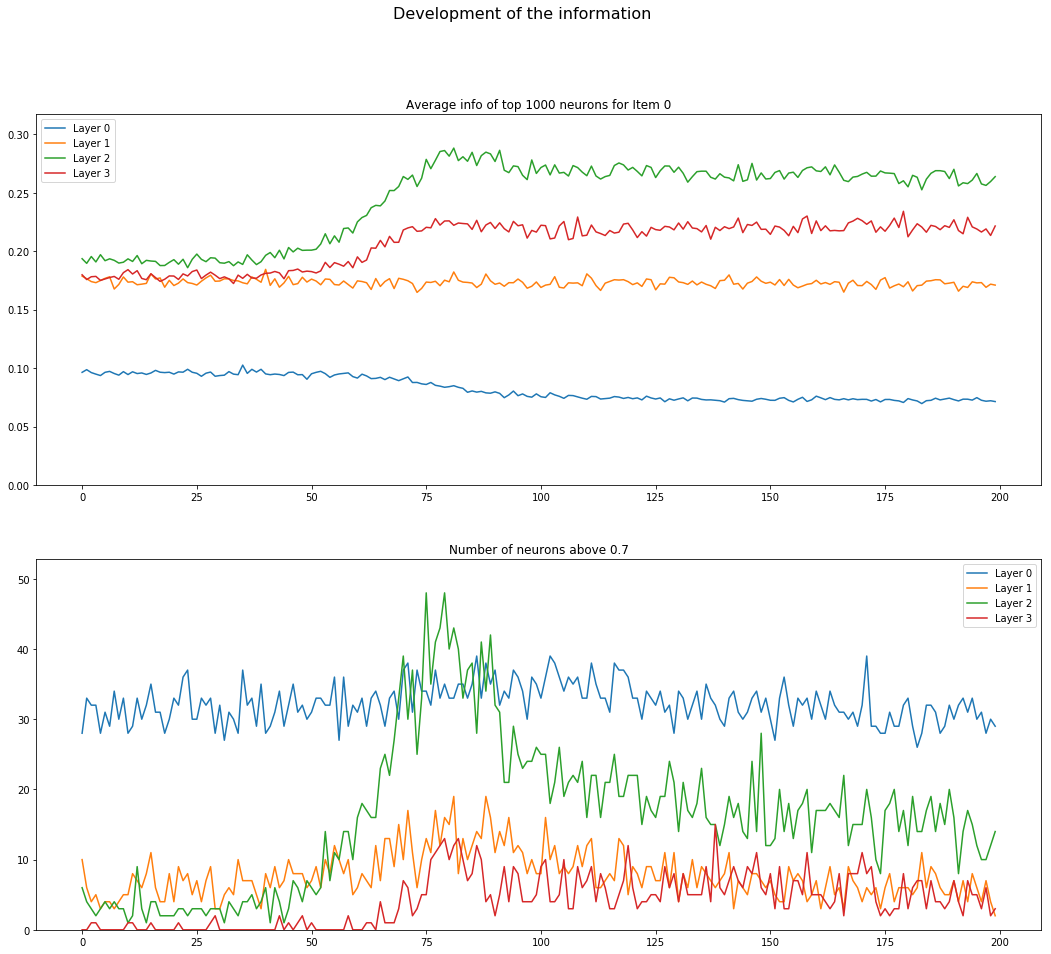

In [24]:
spikeplot.plot_information_development(exc_mutual_info, epochs=[0]+list(epochs), mean_of_top_n=1000, threshold=0.7)

#### Single Cell Information

range(1, 200)


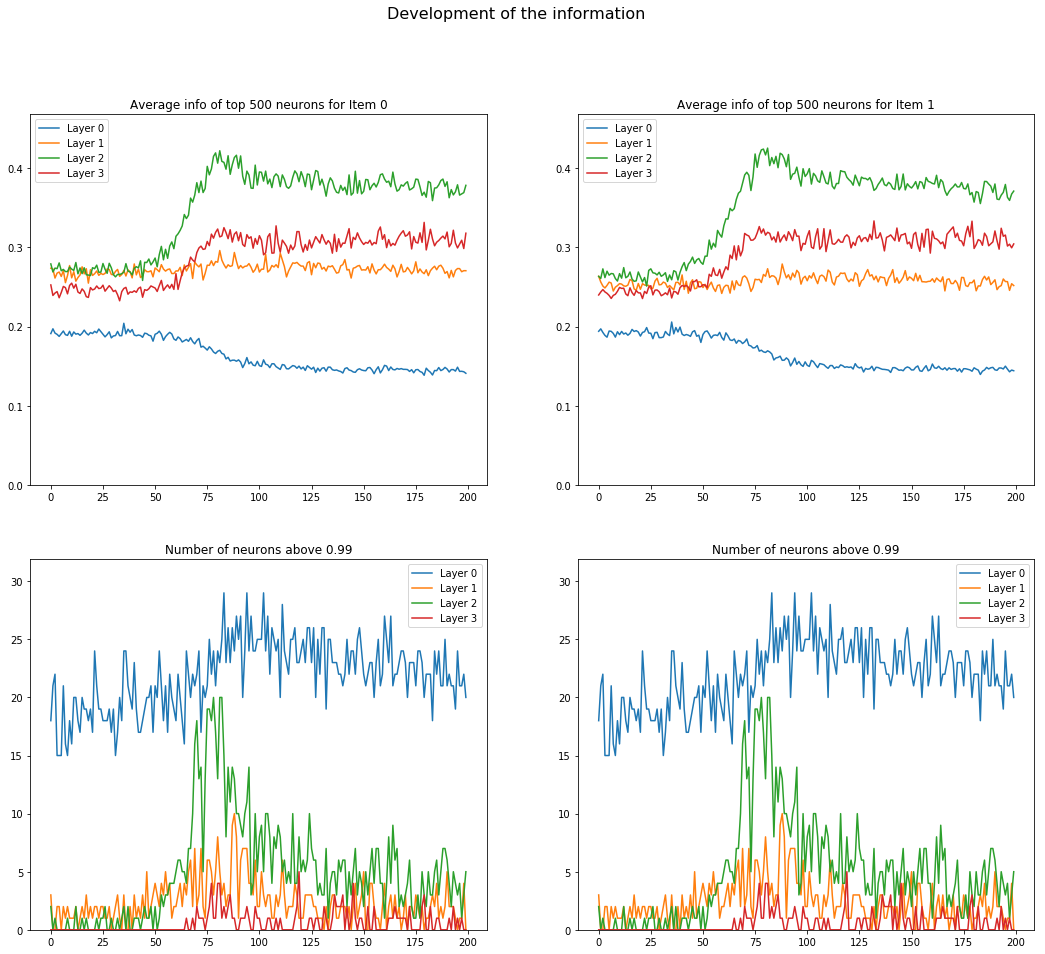

In [25]:
print(epochs)
spikeplot.plot_information_development(exc_information, epochs=[0]+list(epochs), mean_of_top_n=500, threshold=0.99)

In [26]:
len(list(epochs))

199

#### Average higher z response

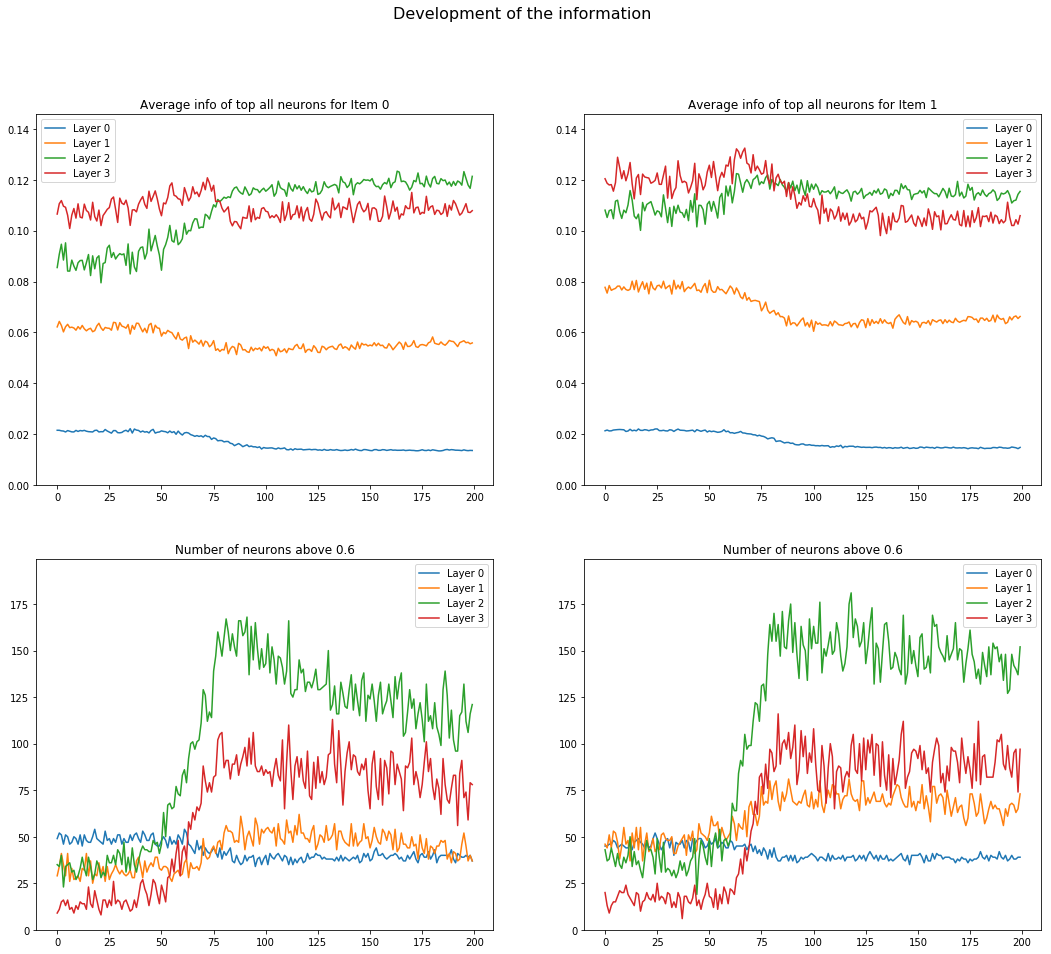

In [27]:
spikeplot.plot_information_development(exc_higher_z_resp, epochs=[0]+list(epochs), threshold=0.6)

#### Number of neurons with this amout of information

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='html5')

ani = spikeplot.plot_animated_histogram(exc_information)
HTML(ani.to_html5_video())

#### Difference in Information between stimuli

In [28]:
diff_1_more_then_0 = exc_information[:, 1, :, :] - exc_information[:, 0, :, :]
# this has shape [epoch, layer, nuron_id] now we need to add singelton dim to make it [epoch, const_1, layer, neuron_id]
# for spikeplot
diff_1_more_then_0 = np.expand_dims(diff_1_more_then_0, 1)
print(diff_1_more_then_0.shape)

(200, 1, 4, 4096)


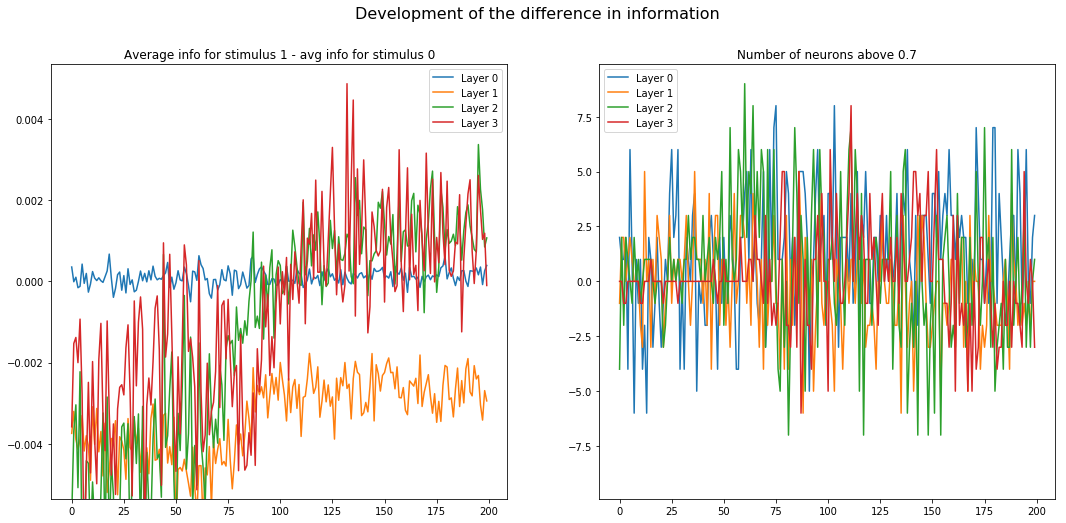

In [29]:
spikeplot.plot_information_difference_development(exc_information, 0.7)

#### 